## In this notebook we aim to provide insight into on what base our model made a prediction
We will utilize the Lime package but then slightly modified.
https://github.com/marcotcr/lime/tree/master/lime

In [1]:
from skimage.segmentation import mark_boundaries
from lime import lime_image
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import numpy as np

/Users/rubensikkes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
explainer = lime_image.LimeImageExplainer(feature_selection= "none")

In [3]:
image_path = "images/michelle_glass_mous.jpg"

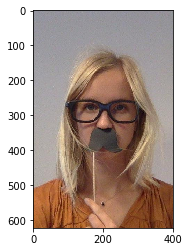

In [4]:
# Loading our image and making sure its in the right color coding
import cv2
im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [18]:
# For Lime we need a prediction function which w
def predict_fn(images):
    # Read in the image_data
    all_predictions = []

    # Unpersists graph from file
    with tf.gfile.FastGFile("glasses/retrained_graph.pb", 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

    with tf.Session() as sess:
        # Feed the image_data as input to the graph and get first prediction
        softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')

        for image_arr in images:
            cv2.imwrite("tmp.jpeg", image_arr)
            image_data = tf.gfile.FastGFile('tmp.jpeg', 'rb').read()

            # Loads label file, strips off carriage return
            label_lines = [line.rstrip() for line 
                               in tf.gfile.GFile("glasses/labels.txt")]


            predictions = sess.run(softmax_tensor, \
                 {'DecodeJpeg/contents:0': image_data})

            # Sort to show labels of first prediction in order of confidence
            top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]
            #print("predictions:", predictions)
            all_predictions.append(predictions[0,:])
    return np.array(all_predictions)

In [21]:
import time
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(im, predict_fn, hide_color=0, num_samples=10, batch_size=10)
print(time.time() - tmp)

[[0.8415018  0.15930729]
 [0.9348056  0.06588985]
 [0.9319109  0.06759264]
 [0.97655153 0.02326351]
 [0.94921607 0.05027102]
 [0.9456671  0.0541336 ]
 [0.9360137  0.06397147]
 [0.85147566 0.14739391]
 [0.93003994 0.06947485]
 [0.9961487  0.00382476]]
1
[[0.8415018  0.15930729]
 [0.9348056  0.06588985]
 [0.9319109  0.06759264]
 [0.97655153 0.02326351]
 [0.94921607 0.05027102]
 [0.9456671  0.0541336 ]
 [0.9360137  0.06397147]
 [0.85147566 0.14739391]
 [0.93003994 0.06947485]
 [0.9961487  0.00382476]]
0
10.35695505142212


In [24]:
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False, min_weight=0)

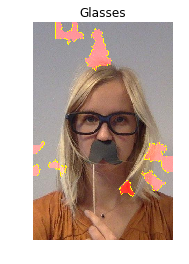

In [25]:
plt.imshow(mark_boundaries(temp , mask))
plt.title("Glasses")
plt.axis('off')
plt.show()

Indicating that our model is mainly looking at the area around glasses. In line with expectations!